<a href="https://colab.research.google.com/github/PaulaNegrete/Sales-Predictions/blob/main/Proyecto2PN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix

In [23]:
path = '/content/train.csv'
df = pd.read_csv(path)
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


**Data Source**

https://www.kaggle.com/competitions/spaceship-titanic/data

**Data Description**

Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
* PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp 
where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
* CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* Destination - The planet the passenger will be debarking to.
* Age - The age of the passenger.
* VIP - Whether the passenger has paid for special VIP service during the voyage.
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* Name - The first and last names of the passenger.
* Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

**Objective**

The task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.

Este es un modelo de clasificacion

In [24]:
df.shape

(8693, 14)

# Data Manipulation

In [25]:
#Delete duplicates: No existen duplicados
df.duplicated().sum()

0

In [26]:
#Remove unnecesary columns: Dropeo las columnas unicas, no interesan para el analisis pues no aportan valor al modelo.
df = df.drop(columns = ['PassengerId','Name','Cabin'])

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Destination   8511 non-null   object 
 3   Age           8514 non-null   float64
 4   VIP           8490 non-null   object 
 5   RoomService   8512 non-null   float64
 6   FoodCourt     8510 non-null   float64
 7   ShoppingMall  8485 non-null   float64
 8   Spa           8510 non-null   float64
 9   VRDeck        8505 non-null   float64
 10  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(4)
memory usage: 687.8+ KB


In [28]:
df.nunique()

HomePlanet         3
CryoSleep          2
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Transported        2
dtype: int64

Variables booleanas

In [29]:
df['CryoSleep'].value_counts()

False    5439
True     3037
Name: CryoSleep, dtype: int64

In [30]:
df['CryoSleep'].isna().sum()

217

In [31]:
#Los NAs representan menos del 3% de la data. Vamos a imputar los missing utilizando la estrategia most frequent.
from statistics import mode
most_freqCS = mode(df['CryoSleep'])
df['CryoSleep'].fillna(most_freqCS,inplace=True)

In [32]:
news = {False:0,True:1}
df['CryoSleep'] = df['CryoSleep'].replace(news)
df['CryoSleep'].value_counts()

0    5656
1    3037
Name: CryoSleep, dtype: int64

In [33]:
df['VIP'].value_counts()

False    8291
True      199
Name: VIP, dtype: int64

In [34]:
df['VIP'].isna().sum()

203

In [35]:
#Los NAs representan menos del 3% de la data. Vamos a imputar los missing utilizando la estrategia most frequent.
most_freqvip = mode(df['VIP'])
df['VIP'].fillna(most_freqvip,inplace=True)

In [36]:
news2 = {False:0,True:1}
df['VIP'] = df['VIP'].replace(news2)
df['VIP'].value_counts()

0    8494
1     199
Name: VIP, dtype: int64

Variables categoricas

In [37]:
df['HomePlanet'].value_counts()

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

In [44]:
df['HomePlanet'].isna().sum()

0

In [45]:
#La estrategia de imputacion sera most frequent para este la variable HomePlanet. NAs representan el 2.3% de la data.
most_freqHP = mode(df['HomePlanet'])
df['HomePlanet'].fillna(most_freqHP,inplace=True)

In [40]:
df['Destination'].value_counts()

TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64

In [41]:
df['Destination'].isna().sum()

182

In [46]:
#La estrategia de imputacion sera most frequent para este la variable Destination. NAs representan el 2% de la data.
most_freqdes = mode(df['Destination'])
df['Destination'].fillna(most_freqdes,inplace=True)

Variables numericas

In [49]:
df.describe()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8693.000000,8514.000000,8693.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,0.349362,28.827930,0.022892,224.687617,458.077203,173.729169,311.138778,304.854791
std,0.476796,14.489021,0.149568,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,38.000000,0.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,1.000000,79.000000,1.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


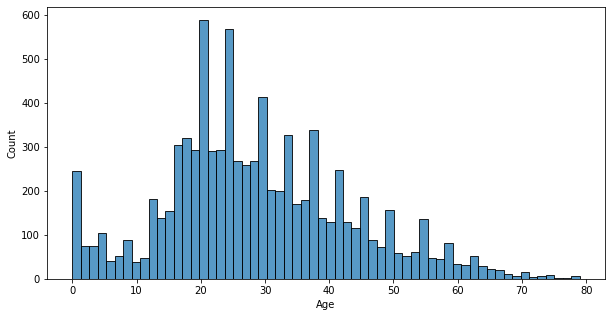

In [59]:
#Analicemos la distribucion de Age
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x="Age", bins = 60);

In [61]:
#Cuantos 0s tenemos en edad? Hay dos opciones, pueden ser bebes de menos de 1 anio o pueden ser errores en la data. Vamos a asumir que son bebes.
df['Age'].value_counts()[0]

178

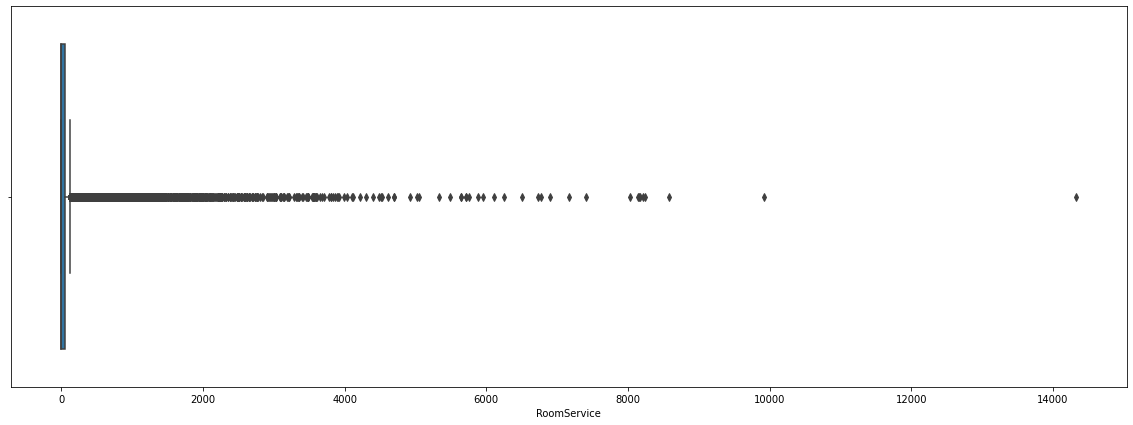

In [64]:
#Vamos a identificar outliers en las variables relacionadas a gasto.
plt.figure(figsize=(20, 7))
sns.boxplot(data=df, x="RoomService");

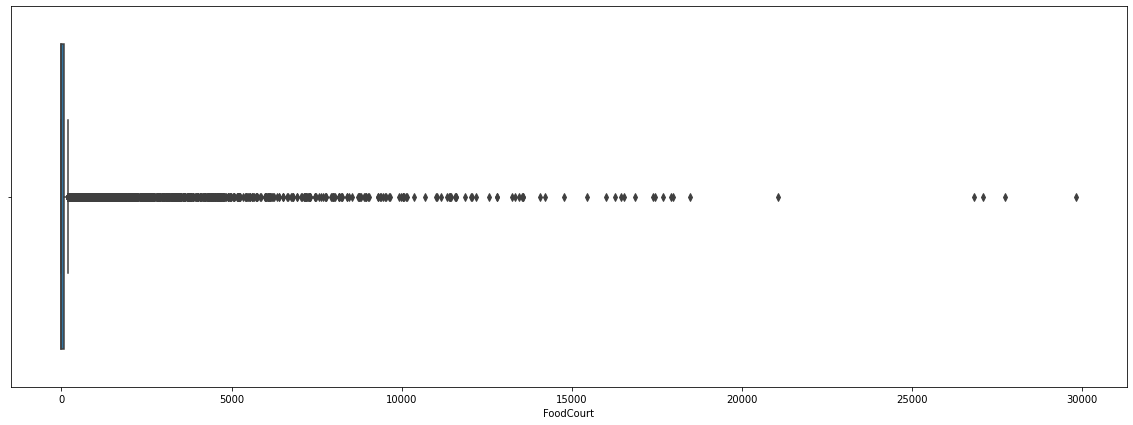

In [65]:
plt.figure(figsize=(20, 7))
sns.boxplot(data=df, x="FoodCourt");

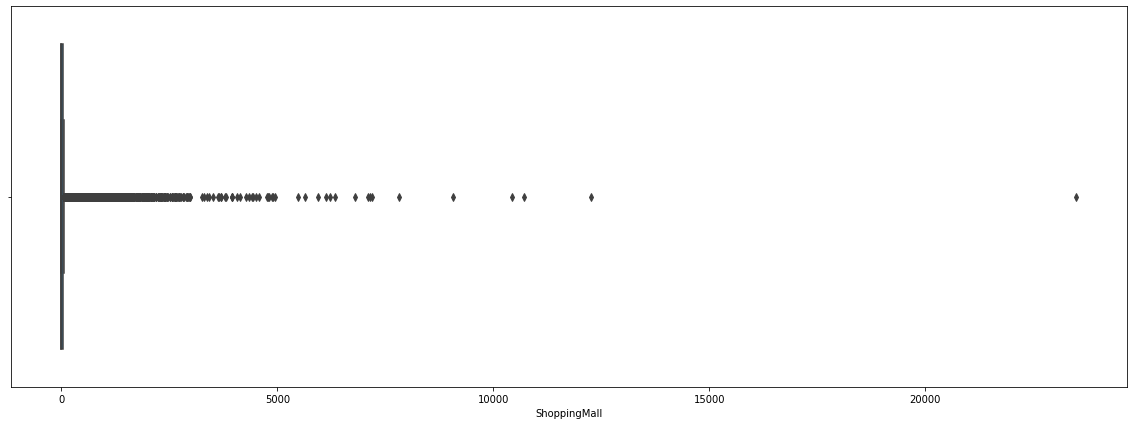

In [66]:
plt.figure(figsize=(20, 7))
sns.boxplot(data=df, x="ShoppingMall");

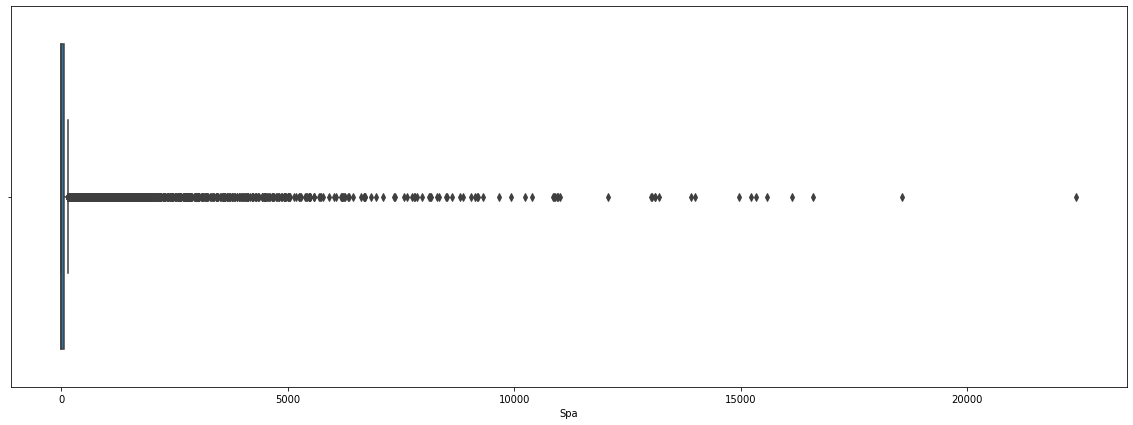

In [67]:
plt.figure(figsize=(20, 7))
sns.boxplot(data=df, x="Spa");

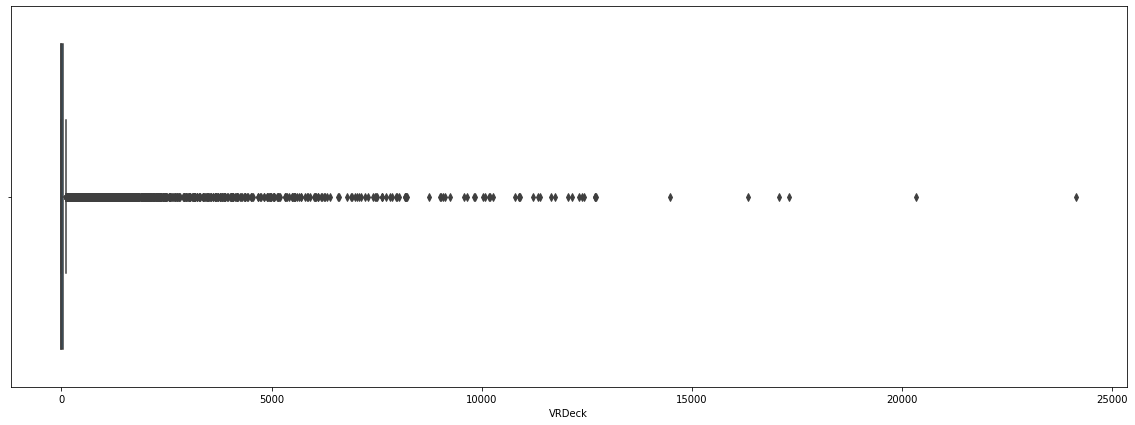

In [68]:
plt.figure(figsize=(20, 7))
sns.boxplot(data=df, x="VRDeck");

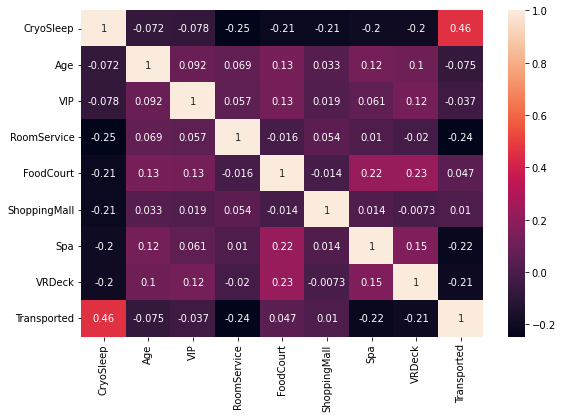

In [69]:
corr = df.corr()
plt.figure(figsize=(9, 6))
sns.heatmap(corr,annot=True);